In [118]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from scipy.special import expit as logistic

import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.25.1


In [119]:
az.style.use("arviz-darkgrid")

RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)


def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

In [ ]:
N = 100

b_0, b_1, b_2, b_3, b_4 = 2, 3, 0.5, -1, -0.75
x_1 = rng.normal(loc=2, scale=2, size=N)
x_2 = rng.normal(loc=5, scale=2, size=N)
y = b_0 + b_1*x_1 + b_2*(pow(x_1,2)) + b_3*x_2 + b_4*pow(x_2,2) + rng.normal(0, 1, N)

f"{x_1.mean():.2f}, {x_1.std():.2f}, {x_2.mean():.2f}, {x_2.std():.2f}, {y.mean():.2f}, {y.std():.2f}"

'1.59, 5.69, 4.69, 2.15, -0.24, 39.61'

In [121]:
x_1_scaled = standardize(x_1)
x_2_scaled = standardize(x_2)
outcome_scaled = standardize(y)

f"{x_1_scaled.mean():.2f}, {x_1_scaled.std():.2f}, {x_2_scaled.mean():.2f}, {x_2_scaled.std():.2f}, {outcome_scaled.mean():.2f}, {outcome_scaled.std():.2f}"

'-0.00, 1.00, -0.00, 1.00, -0.00, 1.00'

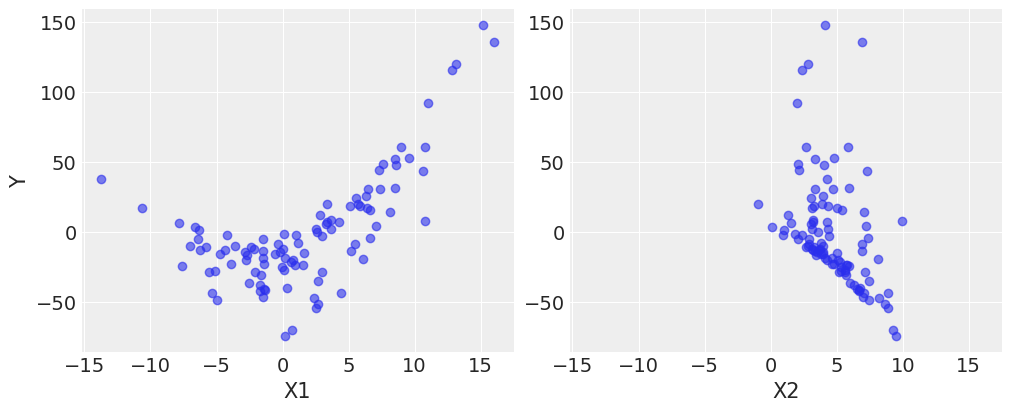

In [122]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(x_1, y, alpha=0.6)
axes[1].scatter(x_2, y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

In [123]:
with pm.Model() as model_1:
    b0_0 = pm.Normal("b0_0", 2, 5)
    b0_1 = pm.Normal("b0_1", 2, 5)
    b0_2 = pm.Normal("b0_2", 2, 5)
    sigma0 = pm.HalfNormal('sigma0', sigma=2)

    x0_0 = pm.Data('x0_0', x_1, dims='obs_id')
    mu0 = pm.Deterministic('mu0', b0_0 + b0_1*x0_0 + b0_2*pow(x0_0,2))

    y0 = pm.Normal('y0', mu=mu0, sigma=sigma0, observed=y)

    idata0 = pm.sample_prior_predictive(draws=50, random_seed=rng)

Sampling: [b0_0, b0_1, b0_2, sigma0, y0]


In [124]:
az.summary(idata0, var_names=['b0_0', 'b0_1', 'b0_2', 'sigma0'])

arviz - WARNING - Shape validation failed: input_shape: (1, 50), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0_0,2.903,4.744,-6.430,10.759,0.869,0.333,34.0,36.0,NaN
b0_1,1.215,5.336,-8.809,6.900,0.708,0.478,57.0,46.0,NaN
b0_2,2.570,4.901,-6.035,10.868,0.623,0.355,66.0,63.0,NaN
sigma0,1.553,1.207,0.025,3.573,0.137,0.103,69.0,55.0,NaN


In [125]:
with model_1:
    idata0.extend(pm.sample(idata_kwargs={'log_likelihood': True},random_seed=rng))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0_0, b0_1, b0_2, sigma0]


Output()

/Users/biplobmac/Code/Seminar_Bayesian_Model_Averaging/.venv/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Text(0.5, 1.0, 'Prior predictive checks -- Flat priors')

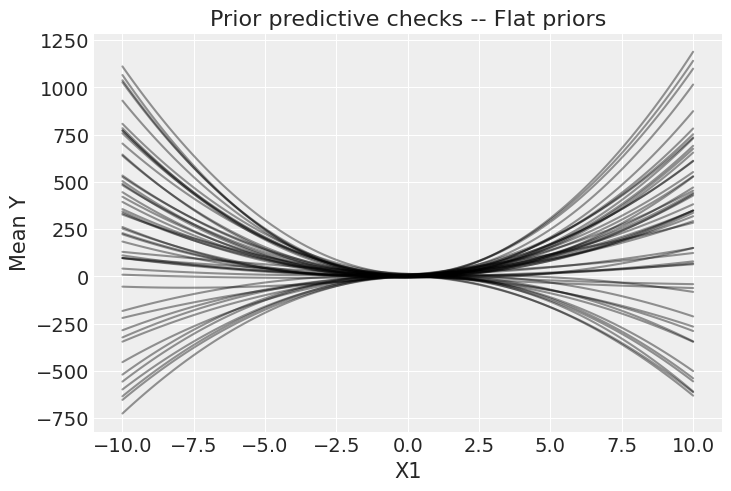

In [126]:
_, ax1 = plt.subplots()

x1 = xr.DataArray(np.linspace(-10, 10, 100), dims=["plot_dim"])
prior0 = idata0.prior
prior_y0 = prior0["b0_0"] + prior0["b0_1"] * x1 + prior0['b0_2'] * pow(x1,2)

ax1.plot(x1, prior_y0.stack(sample=("chain", "draw")), c="k", alpha=0.4)

ax1.set_xlabel("X1")
ax1.set_ylabel("Mean Y")
ax1.set_title("Prior predictive checks -- Flat priors")

array([[<Axes: title={'center': 'b0_0'}>,
        <Axes: title={'center': 'b0_0'}>],
       [<Axes: title={'center': 'b0_1'}>,
        <Axes: title={'center': 'b0_1'}>],
       [<Axes: title={'center': 'b0_2'}>,
        <Axes: title={'center': 'b0_2'}>],
       [<Axes: title={'center': 'sigma0'}>,
        <Axes: title={'center': 'sigma0'}>],
       [<Axes: title={'center': 'mu0'}>, <Axes: title={'center': 'mu0'}>]],
      dtype=object)

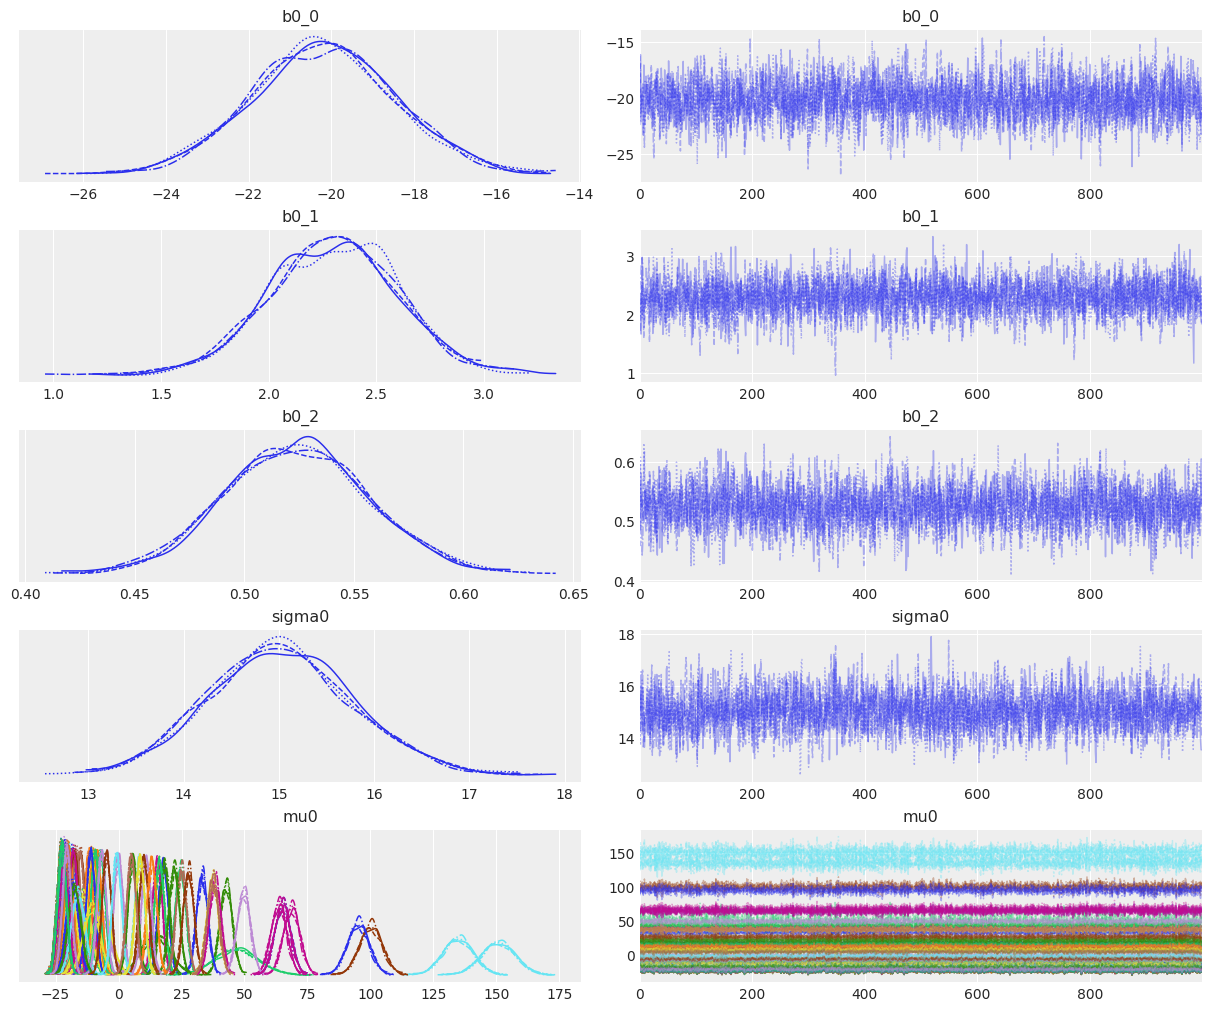

In [127]:
az.plot_trace(idata0)

Sampling: [y0]


Output()

<Axes: xlabel='y0'>

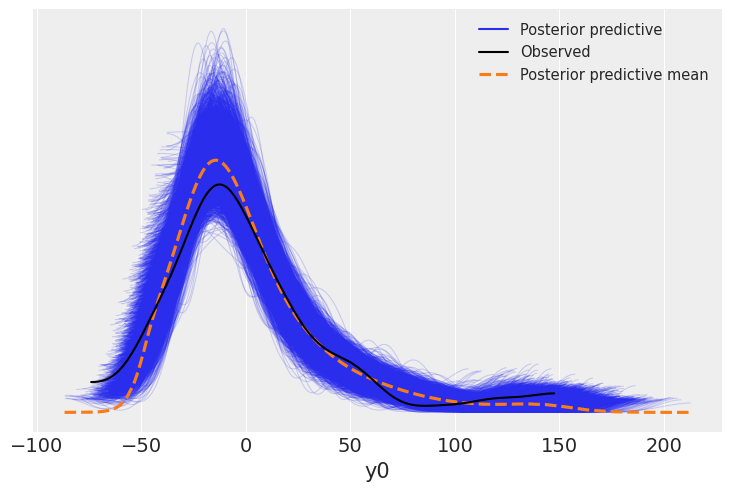

In [128]:
with model_1:
    pm.sample_posterior_predictive(idata0, extend_inferencedata=True, random_seed=rng)
az.plot_ppc(idata0)

In [129]:
with pm.Model() as model_2:
    b1_0 = pm.Normal("b1_0", 2, 5)
    b1_1 = pm.Normal("b1_1", -2, 5)
    b1_2 = pm.Normal("b1_2", -2, 5)
    sigma1 = pm.HalfNormal('sigma1', sigma=2)

    x1_0 = pm.Data('x1_0', x_1, dims='obs_id')
    mu1 = pm.Deterministic('mu1', b1_0 + b1_1*x0_0 + b1_2*pow(x1_0, 2))

    y1 = pm.Normal('y1', mu=mu1, sigma=sigma1, observed=y)

    idata1 = pm.sample_prior_predictive(draws=50, random_seed=rng)

Sampling: [b1_0, b1_1, b1_2, sigma1, y1]


In [130]:
az.summary(idata1, var_names=['b1_0', 'b1_1', 'b1_2', 'sigma1'])

arviz - WARNING - Shape validation failed: input_shape: (1, 50), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b1_0,2.370,4.467,-4.183,10.414,0.815,0.336,33.0,63.0,NaN
b1_1,-2.497,4.672,-10.729,5.711,0.824,0.302,30.0,46.0,NaN
b1_2,-1.860,4.552,-11.451,4.522,0.582,0.319,58.0,63.0,NaN
sigma1,1.436,1.070,0.003,3.343,0.139,0.128,69.0,58.0,NaN


In [131]:
with model_2:
    idata1.extend(pm.sample(idata_kwargs={'log_likelihood': True}, random_seed=rng))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b1_0, b1_1, b1_2, sigma1]


Output()

/Users/biplobmac/Code/Seminar_Bayesian_Model_Averaging/.venv/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Text(0.5, 1.0, 'Prior predictive checks -- Flat priors')

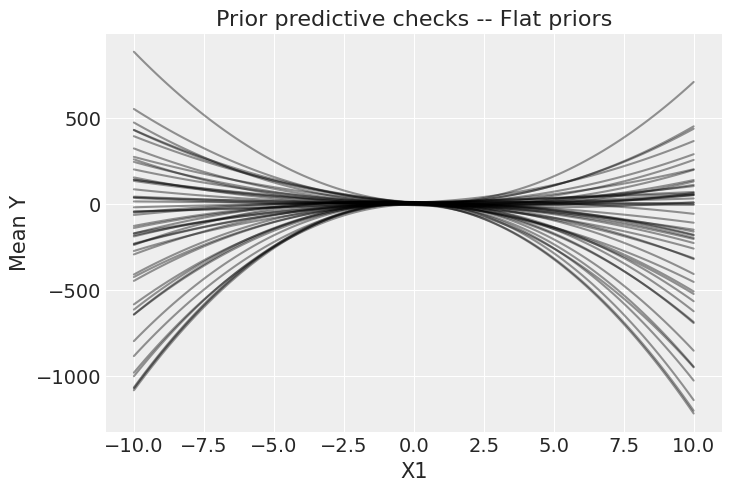

In [132]:
_, ax1 = plt.subplots()

x1 = xr.DataArray(np.linspace(-10, 10, 100), dims=["plot_dim"])
prior1 = idata1.prior
prior_y1 = prior1["b1_0"] + prior1["b1_1"] * x1 + prior1['b1_2'] * pow(x1, 2)

ax1.plot(x1, prior_y1.stack(sample=("chain", "draw")), c="k", alpha=0.4)

ax1.set_xlabel("X1")
ax1.set_ylabel("Mean Y")
ax1.set_title("Prior predictive checks -- Flat priors")

array([[<Axes: title={'center': 'b1_0'}>,
        <Axes: title={'center': 'b1_0'}>],
       [<Axes: title={'center': 'b1_1'}>,
        <Axes: title={'center': 'b1_1'}>],
       [<Axes: title={'center': 'b1_2'}>,
        <Axes: title={'center': 'b1_2'}>],
       [<Axes: title={'center': 'sigma1'}>,
        <Axes: title={'center': 'sigma1'}>],
       [<Axes: title={'center': 'mu1'}>, <Axes: title={'center': 'mu1'}>]],
      dtype=object)

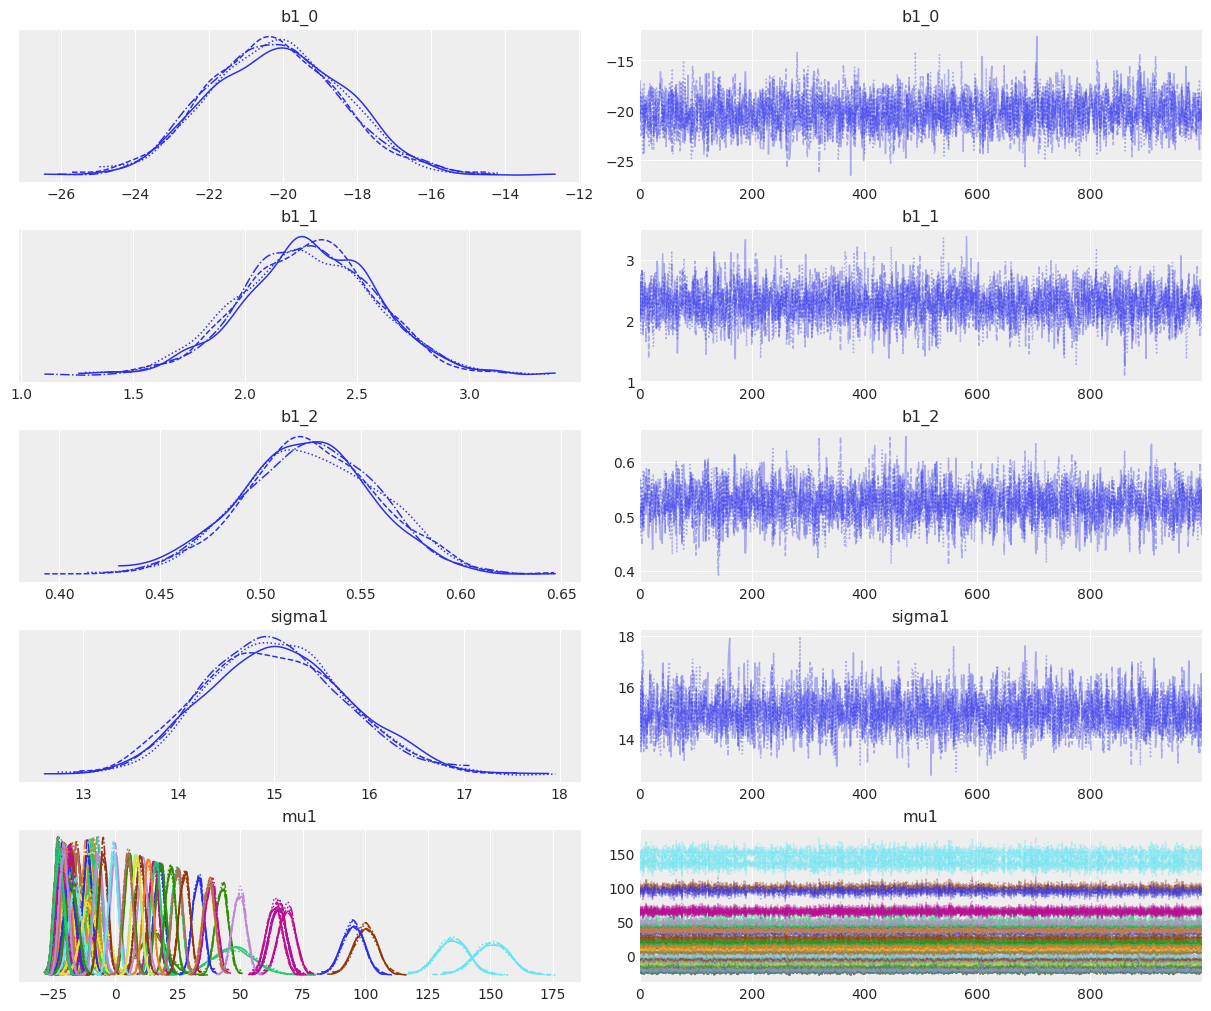

In [133]:
az.plot_trace(idata1)

Sampling: [y1]


Output()

<Axes: xlabel='y1'>

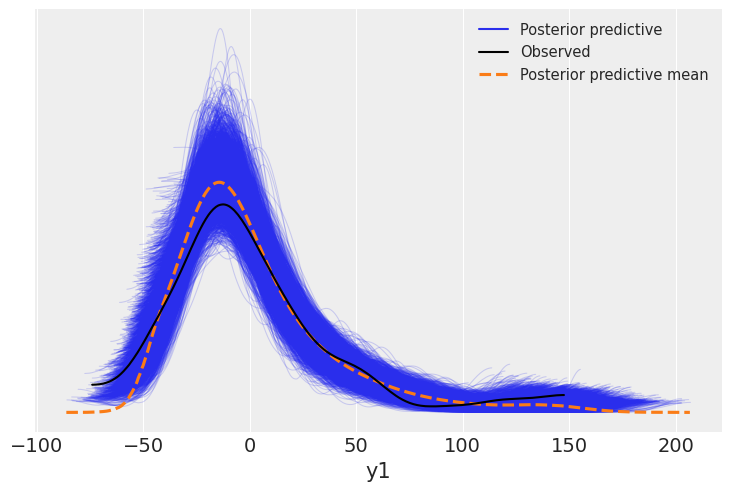

In [134]:
with model_2:
    pm.sample_posterior_predictive(idata1, extend_inferencedata=True, random_seed=rng)
az.plot_ppc(idata1)

In [135]:
models = {
    'x_1': idata0,
    'x_2': idata1
}
comp = az.compare(models, ic='waic')
print(comp)

     rank   elpd_waic    p_waic  elpd_diff  weight         se       dse  \
x_1     0 -443.223799  5.369757    0.00000     1.0  13.622939  0.000000   
x_2     1 -443.239609  5.390888    0.01581     0.0  13.596965  0.062172   

     warning scale  
x_1     True   log  
x_2     True   log  


/Users/biplobmac/Code/Seminar_Bayesian_Model_Averaging/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/biplobmac/Code/Seminar_Bayesian_Model_Averaging/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [137]:
weights = comp['weight']
print("Model Weights:", weights)

Model Weights: x_1    1.0
x_2    0.0
Name: weight, dtype: float64
